In [1]:
%matplotlib inline

import os
import json
from glob import glob
from collections import defaultdict

import dinopy
import yaml
import matplotlib.pyplot as plt
import seaborn
import numpy
import pandas as pd
import networkx
from IPython.display import Image, display

from phasm.io import gfa
from phasm.alignments import AlignmentType
from phasm.assembly_graph import AssemblyGraph
from phasm.bubbles import find_superbubbles

BASE_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))

with open(os.path.join(BASE_DIR, "config.yml")) as f:
    config = yaml.load(f)
    
seaborn.set_context('paper')
seaborn.set_style('whitegrid')

In [7]:
def get_read_alignments(f, reads):
    read_alignments = defaultdict(dict)

    la_iter = map(gfa.gfa2_line_to_la(reads),
                  (l for l in f if l.startswith('E')))

    for la in la_iter:
        a_read, b_read = la.get_oriented_reads()
        read_alignments[a_read][b_read] = la
        read_alignments[b_read][a_read] = la.switch()

    return read_alignments

def get_oriented_read(reads, orid):
    return reads[orid[:-1]].with_orientation(orid[-1])

class ReadDrawer:
    def __init__(self, reads, alignments, rel_reads):
        self.reads = reads
        self.alignments = alignments
        self.rel_reads = {get_oriented_read(self.reads, rid): d for rid, d in rel_reads.items()}
        cmap = seaborn.husl_palette(len(rel_reads))
        self.colours = {r: cmap[i] for i, r in enumerate(self.rel_reads.keys())}
        
        self.reads_drawn = {}
        
    def _get_alignment_start_pos(self, anchor_start: int,
                                 alignment) -> int:
        la_type = alignment.classify()

        # The a-read should be part of the haplotype graph, and is used to
        # anchor any other alignments to this read.
        if la_type in (AlignmentType.OVERLAP_AB, AlignmentType.B_CONTAINED):
            # Haplotype: --------------------------------------------------
            #    A read:           |------|----->
            #    B read:                  |-------------->
            #                           /    (possibly some overhang)
            return max(
                0, anchor_start + alignment.arange[0] - alignment.brange[0]
            )
        elif la_type in (AlignmentType.OVERLAP_BA, AlignmentType.A_CONTAINED):
            # Haplotype: --------------------------------------------------
            #    A read:           |------------>
            #    B read:    |------|-------->
            return max(0, anchor_start - alignment.brange[0])
        
    def plot_aligning_reads(self, ax, graph_reads, x_pos):
        prev = None
        ymid_base = 1.5
        coverage = 0
        for r, xbase in zip(graph_reads, x_pos):
            if r not in self.alignments:
                print(r, repr(r), "has no alignments")
                continue
                
            for b_read, la in self.alignments[r].items():
                if b_read not in self.rel_reads:
                    continue
                    
                x_start = self._get_alignment_start_pos(xbase, la)
                if b_read not in self.reads_drawn:
                    self.reads_drawn[b_read] = ymid_base
                    ax.plot([x_start, x_start + len(b_read)], [ymid_base, ymid_base], color=self.colours[b_read])
                    ymid_base += 1
                    coverage += 1
                    
                # ymid = self.reads_drawn[b_read]
                # ax.fill_between([
                #     x_start + la.brange[0], x_start + la.brange[0] + len(la)], 
                #     ymid-0.25, ymid+0.25,
                #     facecolor=self.colours[b_read],
                #     alpha=0.3
                # )
                
        return coverage
    
def expand_nodes(g, nodes, reads, read_fragments, xbase=0):
    graph_reads = []
    xpos = [xbase]
    prev_node = None
    prev_fragments_len = 0
    for n in nodes:
        sid = n[:-1]
        if prev_node:
            edge_len = g[prev_node][n]['weight']
            if prev_node[:-1] in read_fragments:
                edge_len -= prev_fragments_len
                
            xpos.append(edge_len)
                
                
        r = read_fragments[sid]
        if isinstance(r, gfa.MergedFragment):
            graph_reads.extend(get_oriented_read(reads, rid) for rid in read_fragments[sid].reads)
            for p in read_fragments[sid].prefix_lengths:
                xpos.append(xpos[-1] + p)
                
            prev_fragments_len = sum(read_fragments[sid].prefix_lengths)
        else:
            graph_reads.append(get_oriented_read(reads, n))
            
        prev_node = n
            
    return graph_reads, xpos
                
            
def plot_haplotype_set(g, reads, reads_fragments, alignments, bubble_data, candidate_data):
    ploidy = len(candidate_data['haplotype_set'])
    fig, ax = plt.subplots(ploidy, sharex=True, figsize=(8, 20))
    
    drawer = ReadDrawer(reads, alignments, bubble_data['rel_read_info'])
    
    for i, haplotype_nodes in enumerate(candidate_data['haplotype_set']):
        total_length = 0
        if haplotype_nodes:
            node_iter = iter(haplotype_nodes)
            u = next(node_iter)
            for v in node_iter:
                edge_len = g[u][v]['weight']
                total_length += edge_len
                ax[i].plot([total_length, total_length], [0.25, 0.75], color='black')

                u = v

            ax[i].plot([0, total_length], [0.5, 0.5], color='black')
            
            graph_reads, xpos = expand_nodes(g, haplotype_nodes, reads, reads_fragments)
            drawer.plot_aligning_reads(ax[i], graph_reads, xpos)
        
        extension_nodes = candidate_data['extension'][i]
        if extension_nodes:
            ext_length = 0
            node_iter = iter(candidate_data['extension'][i])
            u = next(node_iter)
            for v in node_iter:
                edge_len = g[u][v]['weight']
                ext_length += edge_len

                x = total_length + ext_length
                ax[i].plot([x, x], [0.25, 0.75], color='green')

                u = v

            ax[i].plot([total_length, total_length+ext_length], [0.5, 0.5], color='green')
            
            graph_reads, xpos = expand_nodes(g, extension_nodes, reads, reads_fragments)
            drawer.plot_aligning_reads(ax[i], graph_reads, xpos)
            

/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/04_phase/component0.bubblechain0-debugdata.json
[['merged136+', 'merged89+', 'read4320-'], ['merged136+', 'merged89+', 'read4320-']]
[['read4320-', 'read10739+', 'merged78+', 'read3870-', 'merged144+', 'read7222+'], ['read4320-', 'read10739+', 'merged78+', 'read3870-', 'merged144+', 'read7222+']]
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy2-60x-error-free/04_phase/component1.bubblechain0-debugdata.json
[['merged55+', 'read9856-', 'merged82+', 'read8253+', 'read7488-'], ['merged55+', 'read9856-', 'merged82+', 'read8253+', 'read7488-']]
[['read7488-', 'merged25+', 'merged24+'], ['read7488-', 'merged25+', 'merged24+']]
/run/media/lucas/data/bioinformatics/thesis-data/assemblies/ploidy3-60x-error-free/04_phase/component1.bubblechain1-debugdata.json
[['read9613-', 'merged15+', 'merged72+', 'merged102+'], ['read9613-', 'merged15+', 'merged72+', 'merged102+'], ['read9613-', 'merged15+', '

KeyboardInterrupt: 

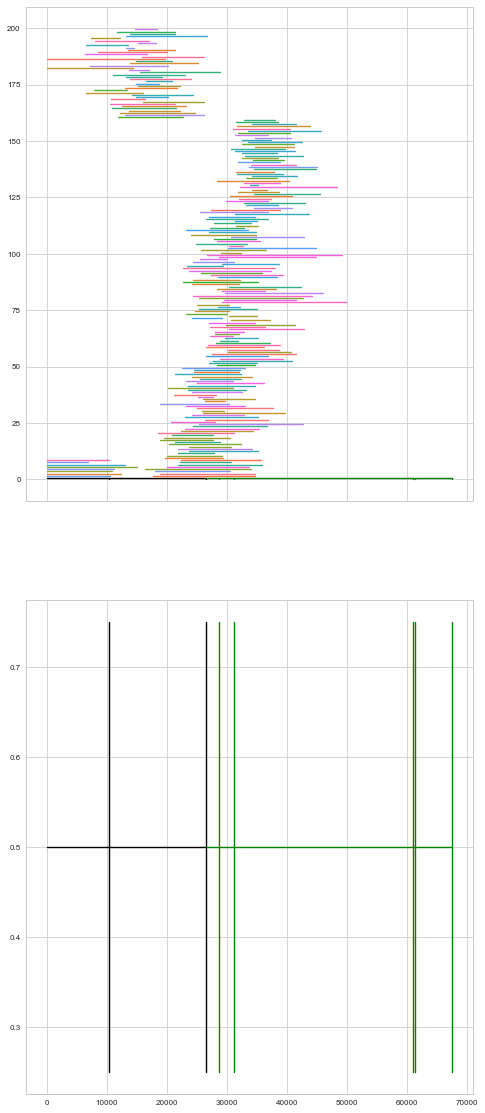

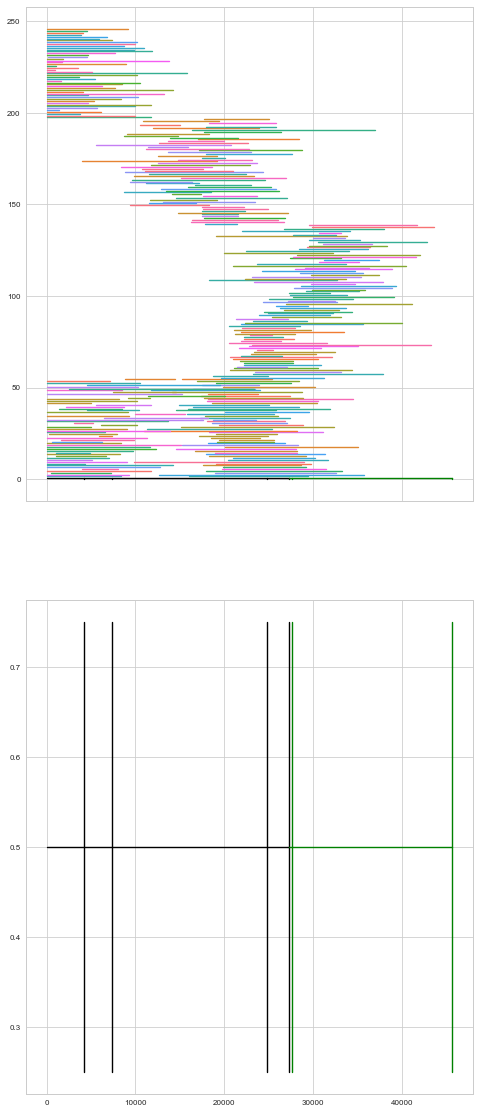

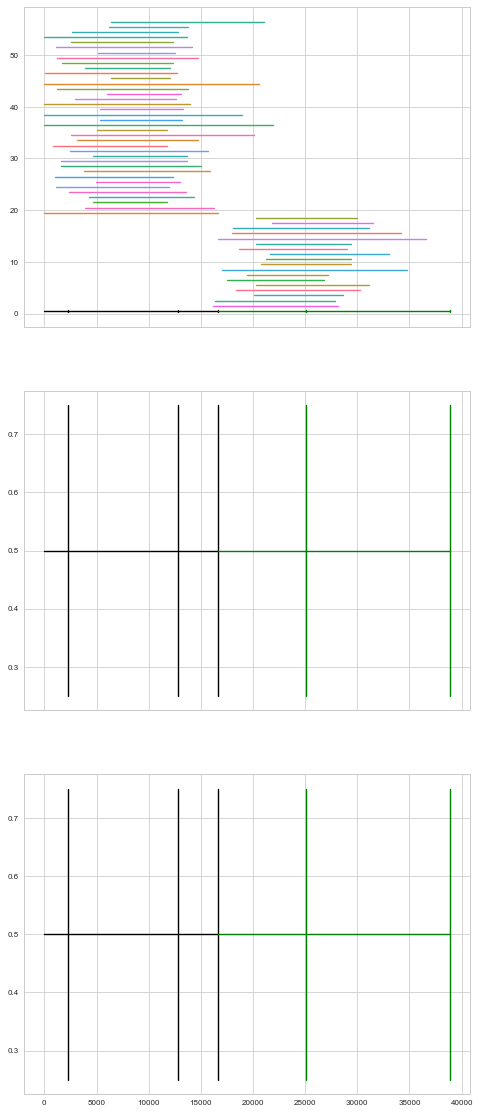

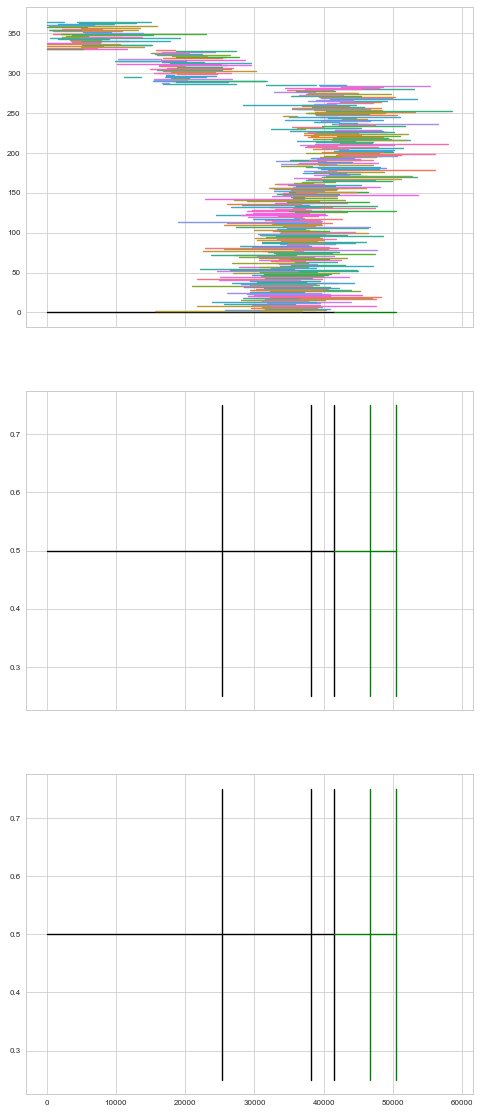

In [8]:
spanning_read_stats = []
read_prob_stats = []
for assembly, asm_config in config['assemblies'].items():
    parts = assembly.split('-')
    ploidy = int(parts[0].replace("ploidy", ""))
    coverage = int(parts[1].replace("x", ""))
    
    asm_folder = os.path.join(BASE_DIR, "assemblies", assembly)
    
    if ploidy != 2 and coverage != 60:
        continue
    
    alignments_gfa = os.path.join(asm_folder, "01_overlap", "alignments.gfa")
    with open(alignments_gfa) as f:
        reads = gfa.gfa2_parse_segments(f)
        
    with open(alignments_gfa) as f:
        alignments = get_read_alignments(f, reads)
        
    for debugdata in glob("{}/04_phase/component[0-9].bubblechain[0-9]-debugdata.json".format(asm_folder)):
        print(debugdata)
        graphml = debugdata.replace("-debugdata.json", ".graphml").replace("04_phase", "03_chain")
        bubblechain_gfa = graphml.replace("graphml", "gfa")
        g = AssemblyGraph(networkx.read_graphml(graphml))
        
        with open(bubblechain_gfa) as f:
            reads_fragments = gfa.gfa2_parse_segments_with_fragments(f)
        
        bubbles = dict(find_superbubbles(g, report_nested=False))
        bubble_entrances = set(bubbles.keys())
        
        curr_bubble = None
        first = True
        with open(debugdata) as f:
            for line in f:
                data = json.loads(line)
                if data['type'] == "new_bubble":
                    curr_bubble = data
                    if data['start_of_block'] == False:
                        dist_between_bubbles = (
                            sum(e[2] for e in g.out_edges_iter(data['entrance'], data=g.edge_len)) /
                                g.out_degree(data['entrance'])
                        )
                        spanning_read_stats.append({
                            'dist': dist_between_bubbles,
                            'spanning_reads': len(data['rel_read_info']),
                            'ploidy': ploidy
                        })
                        
                        if len(data['rel_read_info']) > 600:
                            print(debugdata)
                            print(data['entrance'], data['exit'])
                
                if data['type'] == 'candidate_set':
                    if first:
                        if len(data['haplotype_set'][0]) > 0:
                            print(data['haplotype_set'])
                            print(data['extension'])
                            plot_haplotype_set(g, reads, reads_fragments, alignments, curr_bubble, data)
                            first = False
                            
                        
srdf = pd.DataFrame(spanning_read_stats)
plt.figure()
seaborn.lmplot(x="dist", y="spanning_reads", hue="ploidy", data=srdf, ci=None)
plt.title("Number of spanning reads against the distance between two bubbles")
plt.ylim(ymin=0, ymax=1000)
plt.xlabel("Distance between two bubbles [bases]")
plt.ylabel("Number of spanning reads")

                    